# Compare models on different analyzers

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy
from math import ceil

import keras
import keras.backend
import keras.models
from keras.models import load_model
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


import innvestigate
import innvestigate.utils as iutils
import innvestigate.applications.imagenet


# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")
imgnetutils = imp.load_source("utils_imagenet", "utils_imagenet.py")

Using TensorFlow backend.


## Data
Load the dataset and keep some images from the test set for the analysis.

In [3]:
path = os.getcwd()
model_path = os.path.join(path, 'Trained_Model')

if not os.path.exists(model_path):
    os.makedirs(model_path)

In [4]:
# set parameters of images such that they fit to ResNet-50 model which will be used for training (224, 224, 3)
img_width, img_height = 224, 224

train_data_dir = os.path.join(path, r'..\Animals\Train')
test_data_dir = os.path.join(path, r'..\Animals\Test')

batch_size = 16

In [5]:
## For multiclass case
train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.2, 
                                   rotation_range=20, zoom_range=0.1, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
   train_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
   test_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

Found 19043 images belonging to 10 classes.
Found 7136 images belonging to 10 classes.


In [7]:
def extract_labels(data_path):
    ''' this function returns a list of labels corresponding to the path provided '''
    return os.listdir(data_path)

def get_label(label_categorical, class_list):
    '''
    this fucntion returns the name of the label corresponding the the provided category 
    
    Inputs:
        1) : label_categorical (numpy array) : categorical array containing only a 1 for the selected label
        2) : class_list (list of strings) : list of strings containing the class names (extracted form the directory)
        
    Outputs:
        returns the string containing the correct class name
    '''
    # get index where label_categorical contains the 1
    index = np.where(label_categorical == 1)[0][0]
    # get label from class list using the index and return it
    return class_list[index]

Text(0.5, 1.0, 'squirrel')

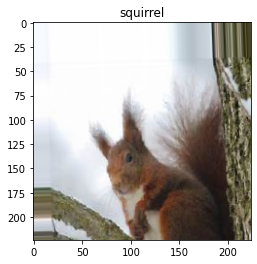

In [8]:
# print one example image and it's corresponding label from training set
batch_nr = 0
img_nr = np.random.choice(np.arange(0, batch_size))

# get list of class names
class_list = extract_labels(train_data_dir)

# get batch -> returns tuple (x, y) where x contains all the images of shape (batch_size, 224, 224, 3) and y contains the 
# corresonding labels of shape (batch_size, 131)
train_batch_tuple = train_generator[batch_nr]
train_batch_data = train_batch_tuple[0]
train_batch_label = train_batch_tuple[1]

# now: get label name
class_name = get_label(train_batch_label[img_nr], class_list)

# image_name = get_label(train_batch_label[img_nr], class_list)
# image_name = image_name.replace(".jpg", "")
# for x in range(len(labels)):
#     if image_name == class_labels['id'][x]:
#         class_name = class_labels['breed'][x]

# now: plot image and set title to corresponding label
img = train_batch_data[img_nr]
plt.imshow(img)
plt.title(class_name)

## Model
The next part trains and evaluates a CNN.

In [9]:
# check locally avaiable devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10782836316744335049
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3206296372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13401492809917428965
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [11]:
n_points = 19043
val_dataset_size = 7136
steps_per_epoch = ceil(n_points / batch_size)
validation_steps=ceil(val_dataset_size/batch_size)

In [12]:
tmp = getattr(innvestigate.applications.imagenet, "resnet50")
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [14]:
model2 = Model(model.input, model.layers[-2].output)
# model2.summary()

In [15]:
x = model2.output

# add a flatten layer
# x = keras.layers.Flatten()(x)

# and a fully connected output/classification layer
predictions = keras.layers.Dense(10, activation='softmax')(x)

# create the full network so we can train on it
model_transfer = Model(inputs=model2.input, outputs=predictions)

In [18]:
# compile
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [19]:
with tf.device("/device:CPU:0"):
    history_resnet50 = model_transfer.fit_generator(train_generator, epochs=10,steps_per_epoch=steps_per_epoch, shuffle = True, verbose = 1,validation_steps=validation_steps, validation_data = test_generator)

Epoch 1/10
1191/1191 [==============================] - 1071s 899ms/step - loss: 0.6841 - acc: 0.7985 - val_loss: 0.2141 - val_acc: 0.9368
Epoch 2/10
1191/1191 [==============================] - 1107s 930ms/step - loss: 0.2740 - acc: 0.9172 - val_loss: 0.1617 - val_acc: 0.9489
Epoch 3/10
1191/1191 [==============================] - 1103s 927ms/step - loss: 0.2155 - acc: 0.9335 - val_loss: 0.1386 - val_acc: 0.9568
Epoch 4/10
1191/1191 [==============================] - 1104s 927ms/step - loss: 0.1786 - acc: 0.9465 - val_loss: 0.1275 - val_acc: 0.9599
Epoch 5/10
1191/1191 [==============================] - 1105s 928ms/step - loss: 0.1637 - acc: 0.9490 - val_loss: 0.1327 - val_acc: 0.9577
Epoch 6/10
1191/1191 [==============================] - 1102s 926ms/step - loss: 0.1402 - acc: 0.9575 - val_loss: 0.1221 - val_acc: 0.9615
Epoch 7/10
1191/1191 [==============================] - 1105s 928ms/step - loss: 0.1289 - acc: 0.9608 - val_loss: 0.1160 - val_acc: 0.9630
Epoch 8/10
1191/1191 [=====

In [20]:
tmp = getattr(innvestigate.applications.imagenet, "vgg16")
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [21]:
model2 = Model(model.input, model.layers[-2].output)
x = model2.output

# and a fully connected output/classification layer
predictions = keras.layers.Dense(10, activation='softmax')(x)

# create the full network so we can train on it
model_transfer_vgg = Model(inputs=model2.input, outputs=predictions)

In [22]:
# compile
model_transfer_vgg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [23]:
with tf.device("/device:CPU:0"):
    history_vgg16 = model_transfer_vgg.fit_generator(train_generator, epochs=10,steps_per_epoch=steps_per_epoch, shuffle = True, verbose = 1,validation_steps=validation_steps, validation_data = test_generator)

Epoch 1/10
1191/1191 [==============================] - 1490s 1s/step - loss: 0.6510 - acc: 0.7833 - val_loss: 0.2706 - val_acc: 0.9140
Epoch 2/10
1191/1191 [==============================] - 1467s 1s/step - loss: 0.2758 - acc: 0.9110 - val_loss: 0.2153 - val_acc: 0.9266
Epoch 3/10
1191/1191 [==============================] - 1468s 1s/step - loss: 0.2158 - acc: 0.9310 - val_loss: 0.1935 - val_acc: 0.9383
Epoch 4/10
1191/1191 [==============================] - 1469s 1s/step - loss: 0.1770 - acc: 0.9442 - val_loss: 0.1685 - val_acc: 0.9479
Epoch 5/10
1191/1191 [==============================] - 1469s 1s/step - loss: 0.1538 - acc: 0.9520 - val_loss: 0.1570 - val_acc: 0.9518
Epoch 6/10
1191/1191 [==============================] - 1449s 1s/step - loss: 0.1347 - acc: 0.9568 - val_loss: 0.1626 - val_acc: 0.9486
Epoch 7/10
1191/1191 [==============================] - 1426s 1s/step - loss: 0.1169 - acc: 0.9632 - val_loss: 0.1482 - val_acc: 0.9528
Epoch 8/10
1191/1191 [==========================

In [29]:
print(history_resnet50.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


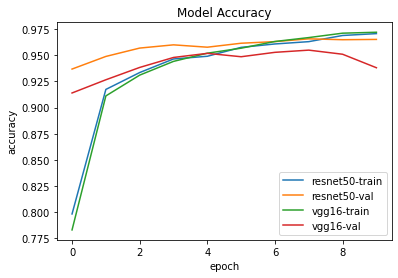

In [31]:
plt.plot(history_resnet50.history['acc'])
plt.plot(history_resnet50.history['val_acc'])
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['resnet50-train', 'resnet50-val','vgg16-train', 'vgg16-val'], loc='lower right')
plt.show()

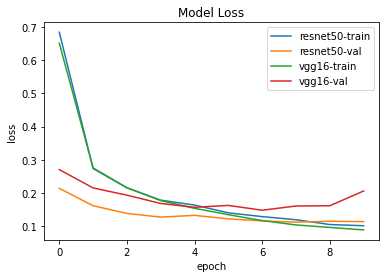

In [33]:
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['resnet50-train', 'resnet50-val','vgg16-train', 'vgg16-val'], loc='upper right')
plt.show()

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [34]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


#Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,        "Gradient"),
    # ("smoothgrad",            {"noise_scale": noise_scale,
    #                            "postprocess": "square"},mnistutils.graymap,        "SmoothGrad"),

    # Signal
    # ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    #("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    #("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
    #("deep_taylor.bounded",   {"low": input_range[0],
    #                           "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    ("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
    # ("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
    # ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    #("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [35]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_transfer)

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

In [36]:
model_wo_softmax_vgg = iutils.keras.graph.model_wo_softmax(model_transfer_vgg)

# Create analyzers.
analyzers_vgg = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax_vgg, # model without softmax output
                                                    **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers_vgg.append(analyzer)

Now we analyze each image with the different analyzers:

In [37]:
# make a prediction and check the result
batch_nr = 0
img_nr = [0,1]
# get batch -> returns tuple (x, y) where x contains all the images of shape (batch_size, 224, 224, 3) and y contains the 
# corresonding labels of shape (batch_size, 131)
test_batch_tuple = test_generator[batch_nr]
test_batch_data = test_batch_tuple[0]
test_batch_class = test_batch_tuple[1]

img = test_batch_data[img_nr[1]]
img2 = test_batch_data[img_nr[1]] # test
print(f'Size of image: {img.shape}')
class_list = extract_labels(test_data_dir)
img = np.expand_dims(img, axis=0)
predictions = model_transfer.predict(img)
label_index = np.argmax(predictions)
label_class_name = class_list[label_index]
print(label_class_name)

Size of image: (224, 224, 3)
spider


In [39]:
n = 10
analyses = {}
texts = {}

test_images = list(zip(test_batch_data[:n], test_batch_class[:n]))

analysis = np.zeros([len(test_images), len(analyzers), 224, 224, 3])
text = []

In [40]:
%%capture

for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    label_index = np.argmax(y)
    label_class_name = class_list[label_index]
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model_transfer.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_class_name,    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % class_list[y_hat] # predicted label
                ))
        
    for aidx, analyzer in enumerate(analyzers):
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            a = x
        elif analyzer:
            # Analyze.
            a = analyzer.analyze(x)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
        else:
            a = np.zeros_like(x)
            # Store the analysis.
        analysis[i, aidx] = a[0]
    analyses[0] = analysis
    texts[0] = text

In [41]:
analysis = np.zeros([len(test_images), len(analyzers), 224, 224, 3])
text = []

In [43]:
for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    label_index = np.argmax(y)
    label_class_name = class_list[label_index]
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax_vgg.predict_on_batch(x)[0]
    prob = model_transfer_vgg.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_class_name,    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % class_list[y_hat] # predicted label
                ))
        
    for aidx, analyzer_vgg in enumerate(analyzers_vgg):
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            b = x
        elif analyzer:
            # Analyze.
            b = analyzer_vgg.analyze(x)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            b = mnistutils.postprocess(b)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            b = methods[aidx][2](b)
        else:
            b = np.zeros_like(x)
            # Store the analysis.
        analysis[i, aidx] = b[0]
    analyses[1] = analysis
    texts[1] = text

Next, we visualize the analysis results:

Image nr. 0, true label: dog


<Figure size 432x288 with 0 Axes>

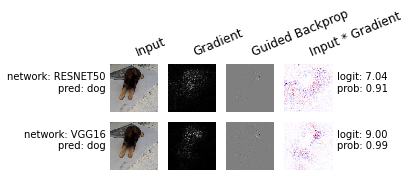

Image nr. 1, true label: spider


<Figure size 432x288 with 0 Axes>

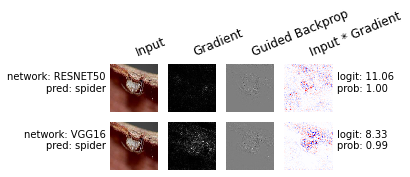

Image nr. 2, true label: squirrel


<Figure size 432x288 with 0 Axes>

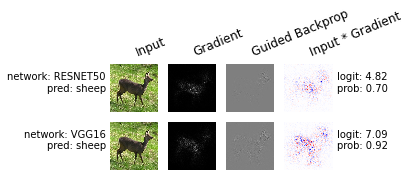

Image nr. 3, true label: dog


<Figure size 432x288 with 0 Axes>

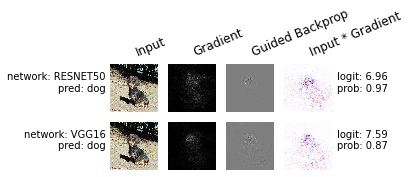

Image nr. 4, true label: spider


<Figure size 432x288 with 0 Axes>

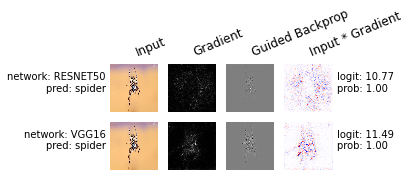

Image nr. 5, true label: elephant


<Figure size 432x288 with 0 Axes>

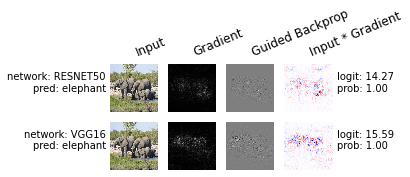

Image nr. 6, true label: dog


<Figure size 432x288 with 0 Axes>

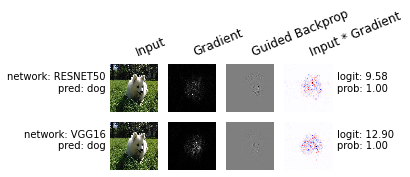

Image nr. 7, true label: dog


<Figure size 432x288 with 0 Axes>

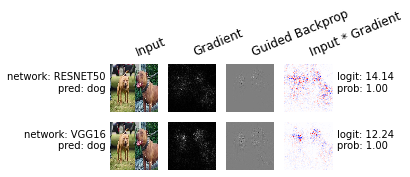

Image nr. 8, true label: butterfly


<Figure size 432x288 with 0 Axes>

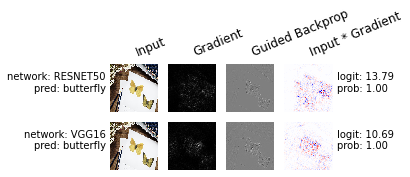

Image nr. 9, true label: cow


<Figure size 432x288 with 0 Axes>

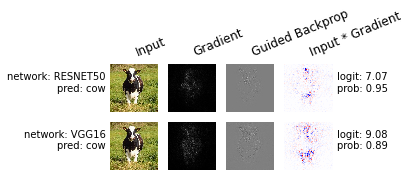

In [44]:
# Prepare common labels
col_labels = [''.join(method[3]) for method in methods]

for image_index in range(len(test_images)):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    analysis, text = analyses[0], texts[0]
    # Prepare the grid as rectengular list
    grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    label = label[image_index]
    row_labels_left.append(('network: {}'.format("RESNET50"),'pred: {}'.format(pred[image_index])))
    row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))
    
    analysis, text = analyses[1], texts[1]
    # Prepare the grid as rectengular list
    grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    label = label[image_index]
    row_labels_left.append(('network: {}'.format("VGG16"),'pred: {}'.format(pred[image_index])))
    row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))
    

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=os.environ.get("plot_file_name", None))